# Table of Contents
 <p>

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numba
import maxentropy
from matplotlib import rc

# plotting settings
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

# more parameters
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14


from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
import os

import scipy.io as sio

In [10]:
# load kato data
fps = 30.3
frames = []
no_animals = 0
for root, dirs, files in os.walk('../input/kato_data/nostim', topdown=False):
    for i, file in enumerate(files):
        mat = sio.loadmat('../input/kato_data/nostim/' + file)

        npmat = np.array(mat['neuronTraces'].tolist())
        smoothnpmat = savgol_filter(npmat, int(np.floor(fps) + 1), 2)

        columns = [a[0] for a in mat['neuronNames'][0]]
        columns2 = [a[0] + '_smooth' for a in mat['neuronNames'][0]]

        temp = pd.DataFrame(npmat)
        temp2 = pd.DataFrame(smoothnpmat)
        temp.columns = columns
        temp2.columns = columns2
        temp['frame'] = temp.index
        temp = pd.concat([temp, temp2], axis=1)
        temp = temp.melt(id_vars='frame', var_name='Neuron', value_name='Fluorescence')
        temp['animal'] = i
        frames += [temp]
        no_animals += 1
df = pd.concat(frames)

In [12]:
# figure out subset of neurons with replicates:
neurons_with_replicates = []
for neuron, group in df.groupby('Neuron'):
    animals = group.animal.unique()
    if len(animals) == no_animals:
        neurons_with_replicates += [neuron]
print(neurons_with_replicates)

['AIBL', 'AIBL_smooth', 'AIBR', 'AIBR_smooth', 'ALA', 'ALA_smooth', 'AVAL', 'AVAL_smooth', 'AVAR', 'AVAR_smooth', 'AVBL', 'AVBL_smooth', 'AVBR', 'AVBR_smooth', 'AVER', 'AVER_smooth', 'RIBL', 'RIBL_smooth', 'RID', 'RID_smooth', 'RIML', 'RIML_smooth', 'RIMR', 'RIMR_smooth', 'RIVL', 'RIVL_smooth', 'RIVR', 'RIVR_smooth', 'RMED', 'RMED_smooth', 'RMEL', 'RMEL_smooth', 'RMER', 'RMER_smooth', 'SMDVR', 'SMDVR_smooth', 'VB01', 'VB01_smooth', 'VB02', 'VB02_smooth']


In [59]:
def get_data_from_worm(i, normed=True):

    a = (df.Neuron.isin(neurons_with_replicates))
    tmp = df[a].copy()
    b = (tmp.Neuron.str.contains('_smooth'))
    
    single_animal = tmp[(tmp.animal == i) & b][['frame', 'Neuron', 'Fluorescence']]
    single_animal.sort_values(['Neuron', 'frame'], inplace=True)
    
    print(single_animal.Neuron.unique())
    single_animal = single_animal.pivot(index='frame', columns='Neuron')
    
    data = single_animal.as_matrix()
    columns = single_animal.columns.droplevel().values.T
    columns = np.array([c.replace('_smooth','') for c in columns]).T
    if normed:
        data = (data - data.mean(axis=0))/data.std(axis=0)
    return data, columns

In [50]:
data0, columns = get_data_from_worm(0)


['AIBL_smooth' 'AIBR_smooth' 'ALA_smooth' 'AVAL_smooth' 'AVAR_smooth'
 'AVBL_smooth' 'AVBR_smooth' 'AVER_smooth' 'RIBL_smooth' 'RID_smooth'
 'RIML_smooth' 'RIMR_smooth' 'RIVL_smooth' 'RIVR_smooth' 'RMED_smooth'
 'RMEL_smooth' 'RMER_smooth' 'SMDVR_smooth' 'VB01_smooth' 'VB02_smooth']


(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5]),
 <a list of 10 Text yticklabel objects>)

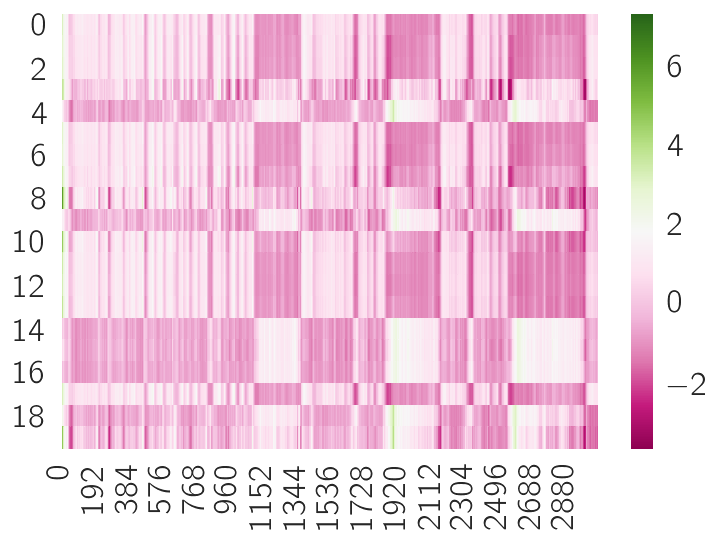

In [51]:
sns.heatmap(data0.T, cmap='PiYG')
plt.yticks(rotation=0)

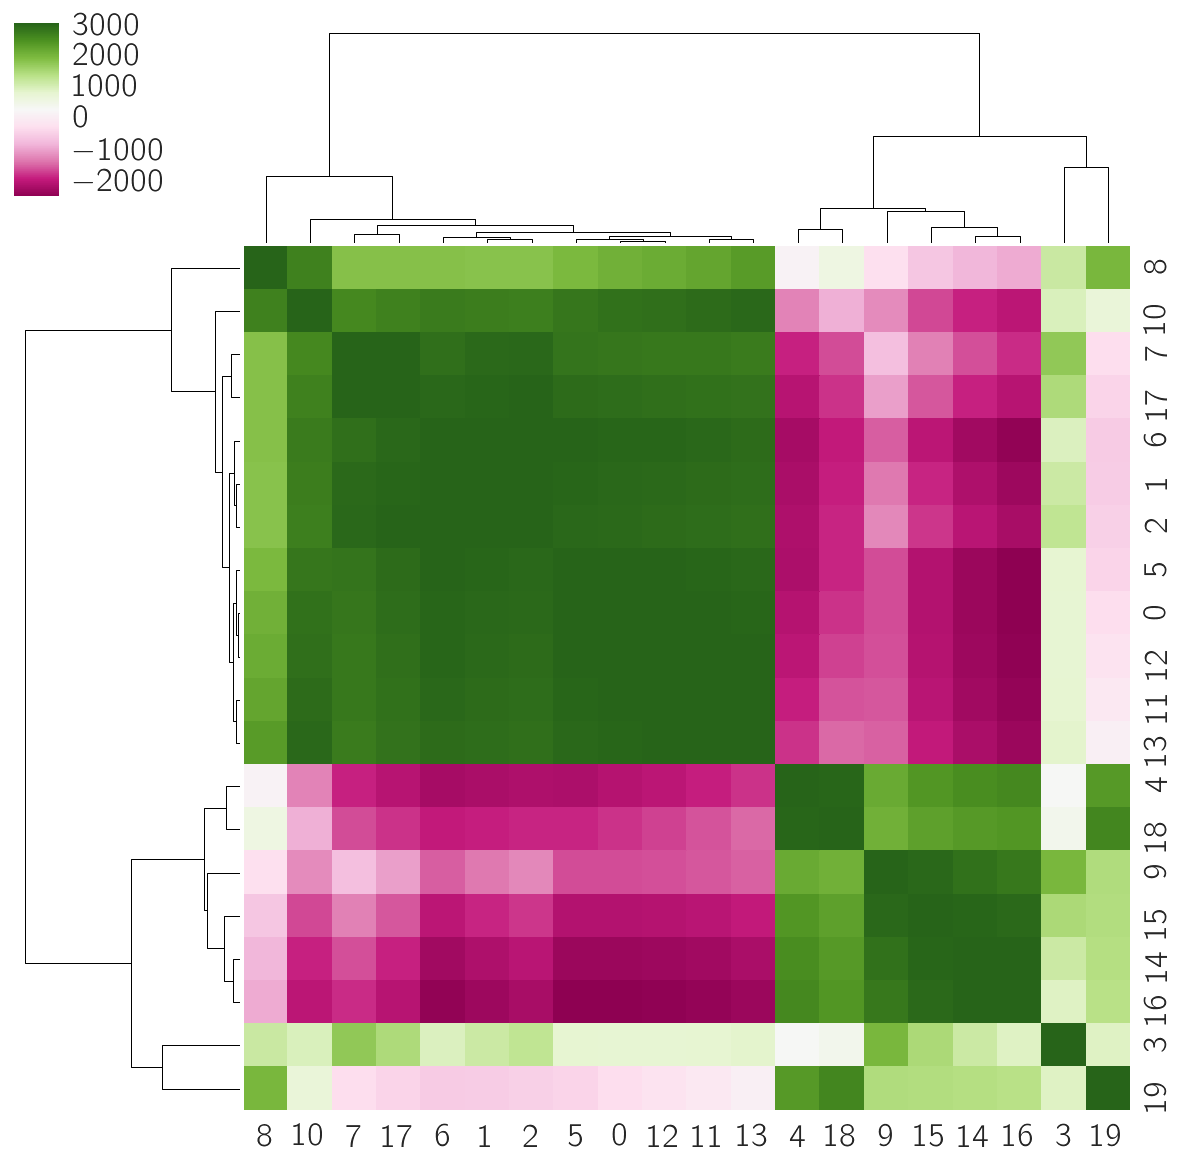

In [52]:
covar = data0.T.dot(data0)
covar = pd.DataFrame(covar, columns = columns, index=columns)
cg = sns.clustermap(covar.as_matrix(), cmap="PiYG")

In [53]:
covar['coNeuron'] = covar.index
melt_covar = covar.melt(id_vars='coNeuron', var_name='Neuron', value_name='covariance')
melt_covar[melt_covar.covariance > np.percentile(melt_covar.covariance, 99)]

,coNeuron,Neuron,covariance
126,AVBR,AVBR,3059.0
189,RID,RID,3059.0
315,RMEL,RMEL,3059.0
399,VB02,VB02,3059.0


In [54]:
data1, columns1 = get_data_from_worm(1)
data2, columns2 = get_data_from_worm(2)
subset = data0
pca = PCA(3)
pca.fit(subset)
print(pca.explained_variance_ratio_)
W = pca.components_

['AIBL_smooth' 'AIBR_smooth' 'ALA_smooth' 'AVAL_smooth' 'AVAR_smooth'
 'AVBL_smooth' 'AVBR_smooth' 'AVER_smooth' 'RIBL_smooth' 'RID_smooth'
 'RIML_smooth' 'RIMR_smooth' 'RIVL_smooth' 'RIVR_smooth' 'RMED_smooth'
 'RMEL_smooth' 'RMER_smooth' 'SMDVR_smooth' 'VB01_smooth' 'VB02_smooth']
['AIBL_smooth' 'AIBR_smooth' 'ALA_smooth' 'AVAL_smooth' 'AVAR_smooth'
 'AVBL_smooth' 'AVBR_smooth' 'AVER_smooth' 'RIBL_smooth' 'RID_smooth'
 'RIML_smooth' 'RIMR_smooth' 'RIVL_smooth' 'RIVR_smooth' 'RMED_smooth'
 'RMEL_smooth' 'RMER_smooth' 'SMDVR_smooth' 'VB01_smooth' 'VB02_smooth']
[0.71152528 0.20207151 0.08568088]


In [55]:
tD0 = W.dot(data0.T)
tD1 = W.dot(data1.T)
tD2 = W.dot(data2.T)

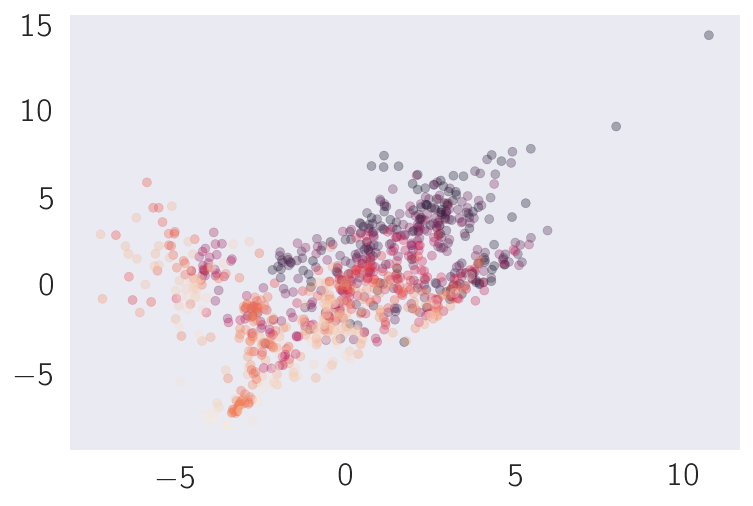

In [58]:
subsample = 10
color = np.linspace(0, 1, len(tD0[0, ::subsample]))
color1 = np.linspace(0, 1, len(tD1[0, ::subsample]))
color2 = np.linspace(0, 1, len(tD2[0, ::subsample]))

plt.scatter(tD0[0, ::subsample], tD0[1, ::subsample], s=20, alpha=0.3, c=color)
plt.scatter(tD1[0, ::subsample], tD1[1, ::subsample], s=20, alpha=0.3, c=color1)
plt.scatter(tD2[0, ::subsample], tD2[1, ::subsample], s=20, alpha=0.3, c=color2)

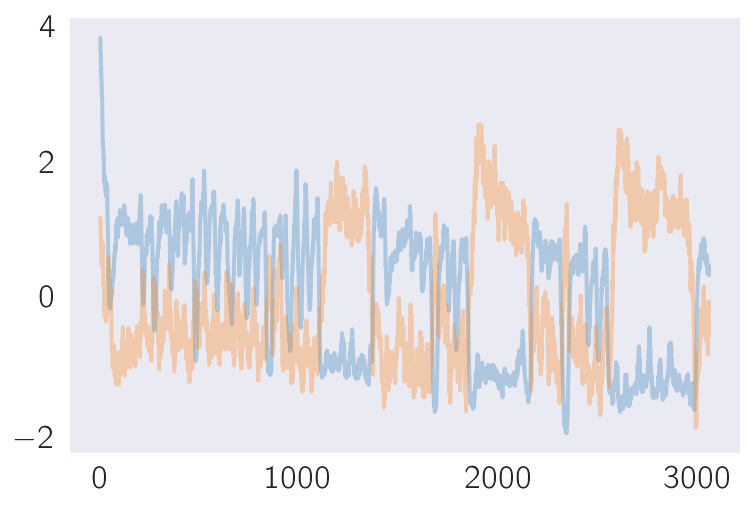

In [73]:
plt.plot(data0[:, 0], alpha=0.3)
plt.plot(data0[:, 15], alpha=0.3)

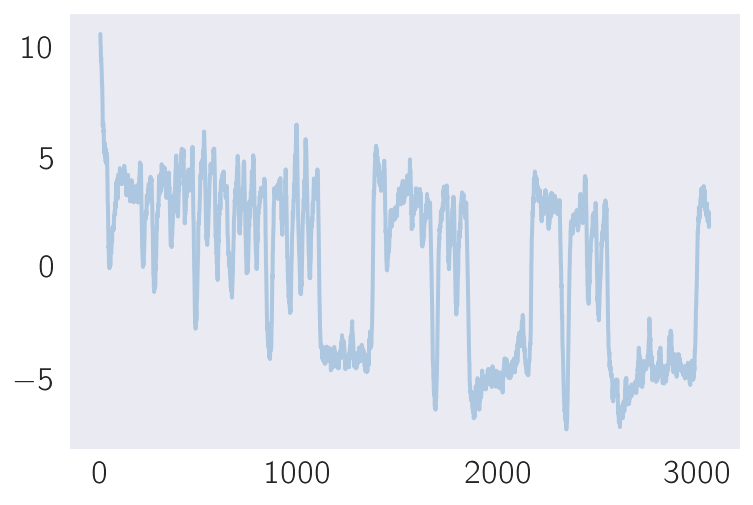

In [67]:
plt.plot(tD0[0, :], alpha=0.3)